# **Relatório econometria - ENADE**

### Preparando o ambiente

* Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

* Selecionando dados

In [2]:
caminho = './bases/microdados-enade-2018econ.csv'
df = pd.read_csv(caminho, sep='\t', encoding='utf-16')
df.shape

(9582, 137)

### Delimitando a pesquisa

* Estudantes da UFPR

In [3]:
df_federais = df[df['Co Categad'] == 10002]

* Apenas estudantes com presença e resultados válidos na prova

In [4]:
df_federais = df_federais[df_federais['Tp Pres'] == 555]

* Selecionando colunas relevantes para o projeto

In [5]:
colunas_a_manter = ['Co Ies', 'Co Grupo', 'Co Curso', 'Co Turno Graduacao', 'Tp Pres', 'Nt Ger', 'Qe I04', 'Qe I05', 'Qe I09', 'Qe I10']
df_federais = df_federais[colunas_a_manter].copy()
df_federais.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3178 entries, 182 to 9537
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Co Ies              3178 non-null   int64 
 1   Co Grupo            3178 non-null   int64 
 2   Co Curso            3178 non-null   int64 
 3   Co Turno Graduacao  3178 non-null   int64 
 4   Tp Pres             3178 non-null   int64 
 5   Nt Ger              3178 non-null   object
 6   Qe I04              3166 non-null   object
 7   Qe I05              3166 non-null   object
 8   Qe I09              3166 non-null   object
 9   Qe I10              3166 non-null   object
dtypes: int64(5), object(5)
memory usage: 273.1+ KB


### Tratando os dados

* Removendo amostras com preenchimento NaN nas colunas 'Qe I04', 'Qe I05', 'Qe I09', 'Qe I10'

In [6]:
colunas_drop = ['Qe I04', 'Qe I05', 'Qe I09', 'Qe I10']
df_federais = df_federais.dropna(subset=colunas_drop).copy()

* Transformando as colunas de escolaridade e trabalho em binárias

In [7]:
colunas_escolaridade = ['Qe I04', 'Qe I05']

mapeamento_escolaridade = {
    'A': 0,
    'B': 0,
    'C': 0,
    'D': 0,
    'E': 1,
    'F': 1,
}

mapeamento_trabalho = {
    'A': 0,
    'B': 1,
    'C': 1,
    'D': 1,
    'E': 1,
    'F': 1,
}

df_federais[colunas_escolaridade] = df_federais[colunas_escolaridade].replace(mapeamento_escolaridade)
df_federais['Qe I10'] = df_federais['Qe I10'].replace(mapeamento_trabalho)

* Alterando type da coluna de notas gerais para float

In [8]:
df_federais['Nt Ger'] = df_federais['Nt Ger'].astype(str)
df_federais['Nt Ger'] = df_federais['Nt Ger'].apply(lambda x: x.replace(',', '') if ',' in x else x)
df_federais['Nt Ger'] = df_federais['Nt Ger'].astype(float) / 10

* Ajustando coluna de pais com superior

In [9]:
df_federais['Pais_com_superior'] = df_federais['Qe I04'] + df_federais['Qe I05']
df_federais['Pais_com_superior'] = df_federais['Pais_com_superior'].apply(lambda x: 0 if x == 0 else 1)
df_federais.drop(columns=['Qe I04', 'Qe I05'], inplace=True)

### Filtrando os grupos

* Notas de estudantes que trabalham e que não trabalham

In [10]:
estudante_trabalha = (df_federais['Qe I10'] == 1)
estudante_nao_trabalha = (df_federais['Qe I10'] == 0)

nota_estudante_trabalha = df_federais[estudante_trabalha]['Nt Ger']
nota_estudante_nao_trabalha = df_federais[estudante_nao_trabalha]['Nt Ger']

* Agrupamento de estudantes que trabalham e não trabalham por tipo de escolaridade dos pais

In [11]:
dados_escolaridade_agrupados = df_federais.groupby('Pais_com_superior')['Qe I10']
porcentagens = dados_escolaridade_agrupados.value_counts(normalize=True) * 100

* Média do desempenho geral dos estudantes agrupada por cada categoria de trabalho

In [12]:
media_por_categoria = df_federais.groupby('Qe I09')[['Nt Ger']].mean()
categorias = media_por_categoria.index
medias_categorias = media_por_categoria.values

### Plotando gráficos para análise

* Escolaridade dos pais e trabalho

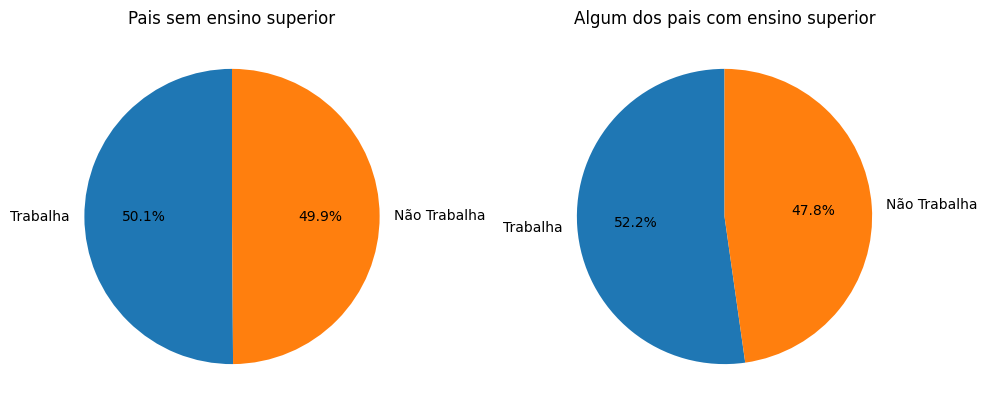

In [13]:
rotulos_variaveis = {
    0: 'Não Trabalha',
    1: 'Trabalha'
}

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

porcentagens[0][0:2].rename(index=rotulos_variaveis).plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes[0], label='')
axes[0].set_title('Pais sem ensino superior')

porcentagens[1][0:2].rename(index=rotulos_variaveis).plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes[1], label='')
axes[1].set_title('Algum dos pais com ensino superior')

plt.tight_layout()
plt.show()



* box-plot para desempenho na nota geral de estudantes que trabalham/estudantes que não trabalham

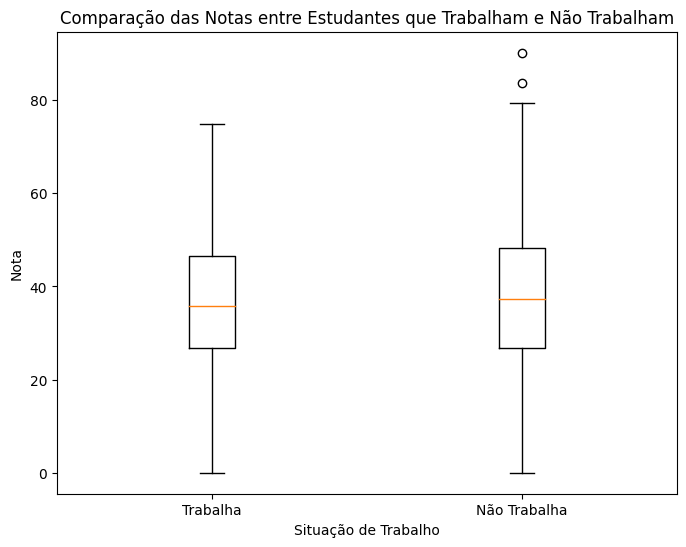

In [14]:
plt.figure(figsize=(8, 6))
plt.boxplot([nota_estudante_trabalha, nota_estudante_nao_trabalha], labels=['Trabalha', 'Não Trabalha'])
plt.title('Comparação das Notas entre Estudantes que Trabalham e Não Trabalham')
plt.xlabel('Situação de Trabalho')
plt.ylabel('Nota')
plt.show()

* Conferindo outliers do gráfico

In [15]:
Q1 = df_federais['Nt Ger'].quantile(0.25)
Q3 = df_federais['Nt Ger'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5*IQR
limite_superior = Q3 + 1.5*IQR

outliers_index = (df_federais['Nt Ger'] < limite_inferior) | (df_federais['Nt Ger'] > limite_superior)

df_federais[outliers_index]

,Co Ies,Co Grupo,Co Curso,Co Turno Graduacao,Tp Pres,Nt Ger,Qe I09,Qe I10,Pais_com_superior
1167,581,13,13714,3,555,83.6,C,0,1
3861,575,13,12948,1,555,90.2,C,0,1
6638,578,13,13292,3,555,79.4,B,0,0


* Média de desempenho geral por cada categoria de trabalho

In [16]:
media_por_categoria = df_federais.groupby('Qe I09')['Nt Ger'].mean()

categorias = media_por_categoria.index
medias = media_por_categoria.values

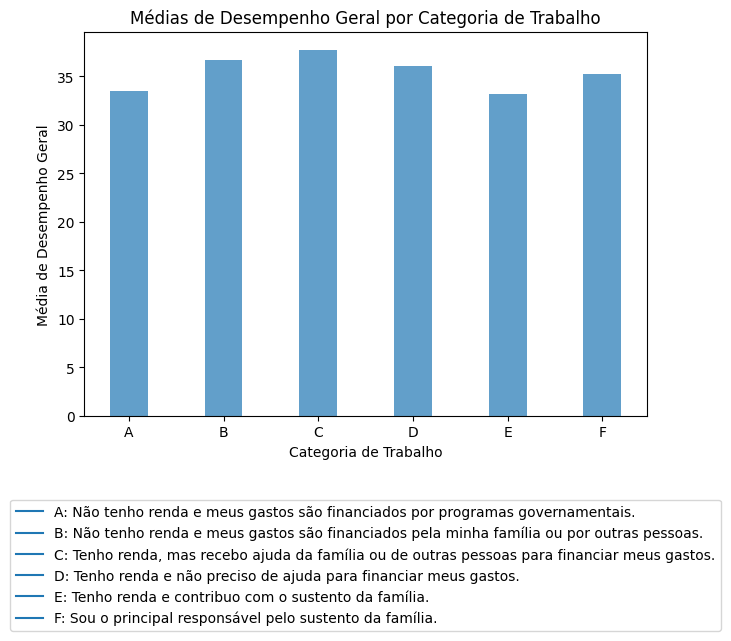

In [17]:
legendas = {
    'A': 'Não tenho renda e meus gastos são financiados por programas governamentais.',
    'B': 'Não tenho renda e meus gastos são financiados pela minha família ou por outras pessoas.',
    'C': 'Tenho renda, mas recebo ajuda da família ou de outras pessoas para financiar meus gastos.',
    'D': 'Tenho renda e não preciso de ajuda para financiar meus gastos.',
    'E': 'Tenho renda e contribuo com o sustento da família.',
    'F': 'Sou o principal responsável pelo sustento da família.',
}

x_pos = range(len(categorias)) 
bar_width = 0.4 

plt.bar(x_pos, medias, width=bar_width, align='center', alpha=0.7, label='Médias')

plt.xlabel('Categoria de Trabalho')
plt.ylabel('Média de Desempenho Geral')

plt.title('Médias de Desempenho Geral por Categoria de Trabalho')

plt.xticks(x_pos, categorias)

plt.tight_layout()
legendas = [plt.Line2D([0], [0],marker='None' , label=f"{cat}: {legendas[cat]}") for cat in categorias]
plt.legend(handles=legendas, loc='upper center', bbox_to_anchor=(0.5, -0.2))

plt.show()


### Testes de hipótese

* Teste qui-quadrado para as variáveis binárias ("Pais com ensino superior" e "Estudante trabalha?")

In [18]:
tabela_contingencia = pd.crosstab(df_federais['Pais_com_superior'], df_federais['Qe I10'])

chi2, p_value, dof, expected = stats.chi2_contingency(tabela_contingencia)


print('Tabela de Contingência:')
print(tabela_contingencia)
print('-'*30)
print('Valor p:', p_value)

Tabela de Contingência:
Qe I10               0    1
Pais_com_superior          
0                  868  872
1                  681  745
------------------------------
Valor p: 0.24742639635041347


* Teste-t para verificar se existe diferença na média de desempenho geral entre estudantes que trabalham e estudantes não trabalham 

In [19]:
t_statistic, p_value = stats.ttest_ind(nota_estudante_trabalha, nota_estudante_nao_trabalha)
print(f'Com o p-valor de: ~{p_value:.3f} e um alfa de 5%, não rejeita-se H0. Sendo assim, conclui-se que as médias não possuem diferença significativa.')

Com o p-valor de: ~0.115 e um alfa de 5%, não rejeita-se H0. Sendo assim, conclui-se que as médias não possuem diferença significativa.


* ANOVA para verificar se existe diferença na média de desempenho geral entre as diferentes categorias de trabalho

In [20]:
df_anova = df_federais[['Nt Ger', 'Qe I09']].copy()
df_anova[['NtGer', 'QeI09']] = df_anova[['Nt Ger', 'Qe I09']]
df_anova.drop(columns=['Nt Ger', 'Qe I09'], inplace=True)
df_anova.head()

,NtGer,QeI09
322,24.6,A
350,45.1,B
351,31.7,C
352,21.2,F
353,4.5,D


In [25]:
import statsmodels.api as sm

modelo_anova = sm.formula.ols('NtGer ~ QeI09', data=df_anova).fit()
tabela_anova = sm.stats.anova_lm(modelo_anova, typ=2)

print("ANOVA Table:")
print(tabela_anova)

multicomp = sm.stats.multicomp.MultiComparison(df_anova['NtGer'], df_anova['QeI09'])
teste_tuckey = multicomp.tukeyhsd()

print("\nTeste de tuckey:")
print(teste_tuckey)

ANOVA Table:
                 sum_sq      df         F   PR(>F)
QeI09       8435.946435     5.0  6.202126  0.00001
Residual  859627.447642  3160.0       NaN      NaN

Teste de tuckey:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B    3.252 0.0318  0.1681   6.336   True
     A      C    4.218 0.0016  1.1053  7.3308   True
     A      D   2.5572 0.2748 -0.8753  5.9897  False
     A      E  -0.3291 0.9998 -3.8543   3.196  False
     A      F   1.8241 0.8613  -2.708  6.3563  False
     B      C    0.966 0.8168 -1.2544  3.1863  False
     B      D  -0.6948 0.9759 -3.3448  1.9552  False
     B      E  -3.5812 0.0031 -6.3502 -0.8122   True
     B      F  -1.4279 0.9097 -5.4004  2.5446  False
     C      D  -1.6608 0.4889 -4.3443  1.0226  False
     C      E  -4.5471 0.0001 -7.3481 -1.7461   True
     C      F  -2.3939  0.526 -6.3888   1.601  False
     D      E  -2.886